In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs
from clmm import ShearAzimuthalAverager

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [22]:
10**14.1

125892541179416.62

In [23]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 1e14','halo_mass < 125892541179416.62','is_central==True','redshift>0.3','redshift<0.35'])

mass_list = massive_halos['halo_mass']
select = (mass_list == np.max(mass_list))

ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl = mass_list[select][0]

print("mass = ", mass_cl/1e14,"*1e14 Msol", "\n ra = ", ra_cl, "\n dec = ", dec_cl,"\n z = ", z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}

mass =  1.1556158195740844 *1e14 Msol 
 ra =  66.90461276350621 
 dec =  -45.279033062083556 
 z =  0.32970929417898986


In [24]:
mass_list.size

15

(array([13.,  2.,  2.,  4.,  2.,  3.,  1.,  1.,  2.,  2.]),
 array([14.00033701, 14.04837319, 14.09640937, 14.14444556, 14.19248174,
        14.24051792, 14.2885541 , 14.33659028, 14.38462647, 14.43266265,
        14.48069883]),
 <a list of 10 Patch objects>)

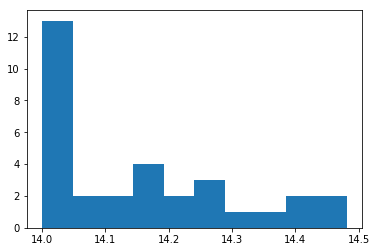

In [21]:
plt.hist(np.log10(mass_list))

### Apply coordinates and redshift cuts to select backgroud galaxies around the cluster

In [13]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
                ]

z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
dat = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))

print ("number of galaxies selected = ", len(dat))

number of galaxies selected =  466975


Text(0.5, 0, 'z')

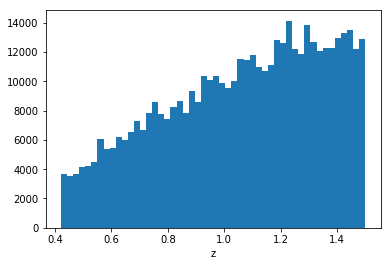

In [14]:
# Histogram of the redshift distribution of selected galaxies
hist = plt.hist(dat['z'], bins=50)
plt.xlabel('z')

### Computes the tangential and cross shear profiles

#### Default binning

/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/astropy/table/row.py:65: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


read g1, g2 directly


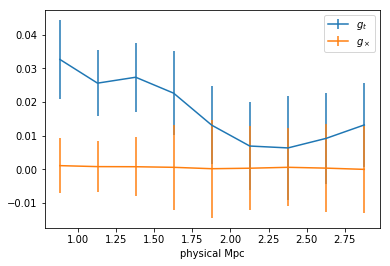

In [15]:
# create an object, given cluster dictionary and galaxy astropy table
saa = ShearAzimuthalAverager(cl_dict,dat)

# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

saa.plot_profile()   

#### User-defined binning

In [27]:
bins = np.linspace(0.1,10)
binned_profile2 = saa.make_shear_profile(bins=bins)
#binned_profile2

/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2917: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/pbs/throng/lsst/software/desc/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


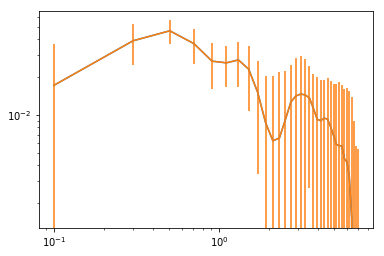

In [35]:
plt.plot(bins[:-1],binned_profile2['g_t'])
plt.errorbar(bins[:-1],binned_profile2['g_t'],binned_profile2['g_t_err'])
plt.xscale('log')
plt.yscale('log')

In [29]:
binned_profile2

radius,ang_separation,g_t,g_x,g_t_err,g_x_err
Mpc,rad,,,,
float64,float64,float64,float64,float64,float64
0.21585118151509872,0.00022439050413005106,0.017229284792084926,0.0010286963173795555,0.01983034343335454,0.01795715759386332
0.4122065084739614,0.00042851387512877874,0.03896146617246413,0.002309447461383304,0.013794819111776225,0.011614100422103108
0.6119740099867462,0.0006361844102567924,0.046762843559833366,0.0020479216970190044,0.009740646965313113,0.009366810899319424
0.8120922408288052,0.0008442195499723583,0.03695560523833315,0.001145213350179087,0.011366618364440983,0.008489744738221982
1.012982319480799,0.0010530570726907285,0.026827844739337303,0.0009070655938510277,0.010743182802616158,0.007558517469933581
1.2140511723599812,0.001262080442151668,0.026027061367236017,0.0008840447326978167,0.00940872926555636,0.00777936913144494
1.4157229384732153,0.0014717305767921443,0.027451950893923233,0.000802096129533216,0.010570655331073911,0.009129131073045093
1.6178797551201516,0.0016818849511269416,0.023170175729081626,0.000651772243191,0.0124275029205061,0.01250166610781535


In [36]:
np.mean()

TypeError: mean() missing 1 required positional argument: 'a'